In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix


## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## Neural network model

In [3]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
        
        print("Depth of the network = number of hidden layers + 1:", D)
        
        for i in range(self.D):
            
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            
            stdv = 2/ np.sqrt(layers_dim[i])
            
            weight = (weight-0.5)*stdv

            weight.requires_grad = True
            
            self.weights.append(weight)
       
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [4]:
input_dim = 784
output_dim = 10
hidden_dim1 = 300

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

Depth of the network = number of hidden layers + 1: 2


## Training parameters

In [5]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

## Training loop

In [6]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []
MSE_tab = []
R_tab = []

In [7]:
batch_size: int = 1000 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        # reset the gradients from previouis iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)

        # backward pass thorught the network
        loss.backward()

        # apply the gradients
        optimizer.step()     

    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )

    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            # pass through the network            
            output: torch.Tensor = model(x)
            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))

        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network            
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))

    ########################################################################
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]

    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
    
    term_I_tab.append(term_1)
    term_II_tab.append(term_2)
    term_IV_tab.append(term_4)
    R_tab.append(R)

    term_1 = round(float(term_1), 6)
    term_2 = round(term_2, 6)

    check = round(1+ term_2 - term_4, 6)
    check2 = round(1+ term_1 + term_2 - term_4, 6)

    print(f"{e}\t{loss} \t term1: {term_1}, \t term2: {term_2} \t {check}\t {check2}")   



0	0.09892469644546509 	 term1: 0.129716, 	 term2: 0.425859 	 1.219552	 1.349268
1	0.07726580649614334 	 term1: 0.050309, 	 term2: 0.315452 	 0.986644	 1.036953
2	0.06781673431396484 	 term1: 0.023599, 	 term2: 0.260819 	 0.8563	 0.879899
3	0.062399860471487045 	 term1: 0.012314, 	 term2: 0.228335 	 0.775132	 0.787446
4	0.058804579079151154 	 term1: 0.007124, 	 term2: 0.207077 	 0.719869	 0.726993
5	0.0561990924179554 	 term1: 0.004747, 	 term2: 0.192283 	 0.679711	 0.684458
6	0.054198604077100754 	 term1: 0.003786, 	 term2: 0.181523 	 0.649125	 0.652911
7	0.05259937793016434 	 term1: 0.003577, 	 term2: 0.173429 	 0.624995	 0.628572
8	0.05128276348114014 	 term1: 0.003779, 	 term2: 0.167178 	 0.605431	 0.60921
9	0.050174444913864136 	 term1: 0.00421, 	 term2: 0.162248 	 0.58922	 0.59343
10	0.049225207418203354 	 term1: 0.004768, 	 term2: 0.15829 	 0.575539	 0.580307
11	0.04840093478560448 	 term1: 0.005392, 	 term2: 0.155067 	 0.56382	 0.569212
12	0.04767705872654915 	 term1: 0.006048, 

102	0.037380900233983994 	 term1: 0.027987, 	 term2: 0.139213 	 0.418481	 0.446468
103	0.037356115877628326 	 term1: 0.028069, 	 term2: 0.139258 	 0.418193	 0.446262
104	0.03733168542385101 	 term1: 0.028151, 	 term2: 0.139303 	 0.417908	 0.446059
105	0.03730759397149086 	 term1: 0.028232, 	 term2: 0.139348 	 0.417628	 0.44586
106	0.03728383406996727 	 term1: 0.028312, 	 term2: 0.139393 	 0.417352	 0.445664
107	0.037260398268699646 	 term1: 0.02839, 	 term2: 0.139438 	 0.41708	 0.44547
108	0.03723727539181709 	 term1: 0.028469, 	 term2: 0.139483 	 0.416812	 0.445281
109	0.03721446916460991 	 term1: 0.028546, 	 term2: 0.139528 	 0.416548	 0.445094
110	0.0371919609606266 	 term1: 0.028622, 	 term2: 0.139573 	 0.416288	 0.44491
111	0.03716975450515747 	 term1: 0.028697, 	 term2: 0.139619 	 0.416032	 0.444729
112	0.03714783489704132 	 term1: 0.028772, 	 term2: 0.139664 	 0.415779	 0.444551
113	0.037126194685697556 	 term1: 0.028846, 	 term2: 0.139709 	 0.41553	 0.444376
114	0.0371048338711

203	0.035880789160728455 	 term1: 0.033503, 	 term2: 0.143713 	 0.401707	 0.43521
204	0.035871751606464386 	 term1: 0.03354, 	 term2: 0.143756 	 0.401612	 0.435152
205	0.03586278855800629 	 term1: 0.033578, 	 term2: 0.143798 	 0.401517	 0.435095
206	0.03585388883948326 	 term1: 0.033615, 	 term2: 0.14384 	 0.401422	 0.435037
207	0.03584505617618561 	 term1: 0.033652, 	 term2: 0.143883 	 0.401329	 0.434981
208	0.03583627939224243 	 term1: 0.033689, 	 term2: 0.143925 	 0.401237	 0.434926
209	0.03582756966352463 	 term1: 0.033725, 	 term2: 0.143967 	 0.401145	 0.43487
210	0.035818930715322495 	 term1: 0.033761, 	 term2: 0.144009 	 0.401053	 0.434814
211	0.03581034392118454 	 term1: 0.033798, 	 term2: 0.144051 	 0.400963	 0.434761
212	0.03580182045698166 	 term1: 0.033834, 	 term2: 0.144093 	 0.400873	 0.434707
213	0.03579336032271385 	 term1: 0.033869, 	 term2: 0.144135 	 0.400784	 0.434653
214	0.03578495606780052 	 term1: 0.033905, 	 term2: 0.144177 	 0.400696	 0.434601
215	0.03577661141

304	0.035210903733968735 	 term1: 0.036489, 	 term2: 0.147609 	 0.39486	 0.431349
305	0.03520604223012924 	 term1: 0.036512, 	 term2: 0.147643 	 0.394812	 0.431324
306	0.03520119935274124 	 term1: 0.036535, 	 term2: 0.147677 	 0.394764	 0.431299
307	0.03519638627767563 	 term1: 0.036558, 	 term2: 0.147711 	 0.394717	 0.431275
308	0.035191599279642105 	 term1: 0.036581, 	 term2: 0.147745 	 0.39467	 0.431251
309	0.035186830908060074 	 term1: 0.036604, 	 term2: 0.147779 	 0.394623	 0.431227
310	0.03518208861351013 	 term1: 0.036627, 	 term2: 0.147813 	 0.394577	 0.431204
311	0.03517737612128258 	 term1: 0.03665, 	 term2: 0.147847 	 0.394532	 0.431182
312	0.035172682255506516 	 term1: 0.036672, 	 term2: 0.147881 	 0.394486	 0.431158
313	0.03516801446676254 	 term1: 0.036695, 	 term2: 0.147915 	 0.394441	 0.431136
314	0.03516336530447006 	 term1: 0.036717, 	 term2: 0.147948 	 0.394395	 0.431112
315	0.03515874594449997 	 term1: 0.03674, 	 term2: 0.147982 	 0.394351	 0.431091
316	0.0351541489

405	0.03481999412178993 	 term1: 0.038438, 	 term2: 0.150677 	 0.391148	 0.429586
406	0.0348169319331646 	 term1: 0.038454, 	 term2: 0.150703 	 0.391119	 0.429573
407	0.03481386601924896 	 term1: 0.03847, 	 term2: 0.15073 	 0.391092	 0.429562
408	0.03481082618236542 	 term1: 0.038486, 	 term2: 0.150756 	 0.391063	 0.429549
409	0.03480779752135277 	 term1: 0.038501, 	 term2: 0.150783 	 0.391036	 0.429537
410	0.034804780036211014 	 term1: 0.038517, 	 term2: 0.150809 	 0.391008	 0.429525
411	0.03480177000164986 	 term1: 0.038533, 	 term2: 0.150835 	 0.39098	 0.429513
412	0.03479877859354019 	 term1: 0.038549, 	 term2: 0.150862 	 0.390953	 0.429502
413	0.03479579836130142 	 term1: 0.038564, 	 term2: 0.150888 	 0.390926	 0.42949
414	0.03479282185435295 	 term1: 0.03858, 	 term2: 0.150914 	 0.390899	 0.429479
415	0.03478986769914627 	 term1: 0.038595, 	 term2: 0.15094 	 0.390872	 0.429467
416	0.034786924719810486 	 term1: 0.03861, 	 term2: 0.150966 	 0.390845	 0.429455
417	0.0347839891910553

506	0.034562598913908005 	 term1: 0.039814, 	 term2: 0.153058 	 0.388838	 0.428652
507	0.034560490399599075 	 term1: 0.039826, 	 term2: 0.153079 	 0.38882	 0.428646
508	0.034558385610580444 	 term1: 0.039837, 	 term2: 0.153099 	 0.388801	 0.428638
509	0.034556299448013306 	 term1: 0.039849, 	 term2: 0.15312 	 0.388783	 0.428632
510	0.03455421328544617 	 term1: 0.03986, 	 term2: 0.153141 	 0.388765	 0.428625
511	0.034552134573459625 	 term1: 0.039872, 	 term2: 0.153161 	 0.388746	 0.428618
512	0.03455005958676338 	 term1: 0.039883, 	 term2: 0.153182 	 0.388729	 0.428612
513	0.034547995775938034 	 term1: 0.039895, 	 term2: 0.153202 	 0.38871	 0.428605
514	0.03454593941569328 	 term1: 0.039906, 	 term2: 0.153222 	 0.388692	 0.428598
515	0.03454389050602913 	 term1: 0.039917, 	 term2: 0.153243 	 0.388675	 0.428592
516	0.03454184532165527 	 term1: 0.039929, 	 term2: 0.153263 	 0.388657	 0.428586
517	0.034539803862571716 	 term1: 0.03994, 	 term2: 0.153283 	 0.388638	 0.428578
518	0.03453777

607	0.03438097611069679 	 term1: 0.040836, 	 term2: 0.154927 	 0.387273	 0.428109
608	0.034379445016384125 	 term1: 0.040845, 	 term2: 0.154944 	 0.38726	 0.428105
609	0.03437792509794235 	 term1: 0.040853, 	 term2: 0.15496 	 0.387247	 0.4281
610	0.03437640517950058 	 term1: 0.040862, 	 term2: 0.154976 	 0.387234	 0.428096
611	0.034374888986349106 	 term1: 0.040871, 	 term2: 0.154993 	 0.387222	 0.428093
612	0.03437338396906853 	 term1: 0.04088, 	 term2: 0.155009 	 0.387208	 0.428088
613	0.03437187522649765 	 term1: 0.040888, 	 term2: 0.155025 	 0.387195	 0.428083
614	0.03437037393450737 	 term1: 0.040897, 	 term2: 0.155042 	 0.387184	 0.428081
615	0.03436888009309769 	 term1: 0.040906, 	 term2: 0.155058 	 0.387171	 0.428077
616	0.0343673899769783 	 term1: 0.040914, 	 term2: 0.155074 	 0.387158	 0.428072
617	0.034365907311439514 	 term1: 0.040923, 	 term2: 0.15509 	 0.387145	 0.428068
618	0.03436442092061043 	 term1: 0.040931, 	 term2: 0.155106 	 0.387133	 0.428064
619	0.03436294198036

708	0.034246861934661865 	 term1: 0.041623, 	 term2: 0.156421 	 0.386148	 0.427771
709	0.03424571454524994 	 term1: 0.04163, 	 term2: 0.156434 	 0.386138	 0.427768
710	0.03424456715583801 	 term1: 0.041636, 	 term2: 0.156447 	 0.386128	 0.427764
711	0.034243423491716385 	 term1: 0.041643, 	 term2: 0.156461 	 0.386119	 0.427762
712	0.03424227982759476 	 term1: 0.04165, 	 term2: 0.156474 	 0.38611	 0.42776
713	0.034241143614053726 	 term1: 0.041657, 	 term2: 0.156487 	 0.3861	 0.427757
714	0.034240011125802994 	 term1: 0.041664, 	 term2: 0.1565 	 0.38609	 0.427754
715	0.03423887863755226 	 term1: 0.041671, 	 term2: 0.156513 	 0.386081	 0.427752
716	0.03423774987459183 	 term1: 0.041677, 	 term2: 0.156526 	 0.386071	 0.427748
717	0.03423662856221199 	 term1: 0.041684, 	 term2: 0.156539 	 0.386062	 0.427746
718	0.034235503524541855 	 term1: 0.041691, 	 term2: 0.156552 	 0.386053	 0.427744
719	0.034234385937452316 	 term1: 0.041698, 	 term2: 0.156565 	 0.386044	 0.427742
720	0.0342332720756

809	0.03414452448487282 	 term1: 0.042246, 	 term2: 0.157635 	 0.385302	 0.427548
810	0.034143637865781784 	 term1: 0.042251, 	 term2: 0.157646 	 0.385295	 0.427546
811	0.03414274752140045 	 term1: 0.042257, 	 term2: 0.157657 	 0.385288	 0.427545
812	0.034141864627599716 	 term1: 0.042262, 	 term2: 0.157668 	 0.385281	 0.427543
813	0.03414097800850868 	 term1: 0.042268, 	 term2: 0.157679 	 0.385274	 0.427542
814	0.034140098839998245 	 term1: 0.042273, 	 term2: 0.15769 	 0.385267	 0.42754
815	0.03413921967148781 	 term1: 0.042279, 	 term2: 0.1577 	 0.385259	 0.427538
816	0.03413834050297737 	 term1: 0.042284, 	 term2: 0.157711 	 0.385252	 0.427536
817	0.03413746505975723 	 term1: 0.04229, 	 term2: 0.157722 	 0.385245	 0.427535
818	0.034136589616537094 	 term1: 0.042295, 	 term2: 0.157733 	 0.385238	 0.427533
819	0.03413572162389755 	 term1: 0.0423, 	 term2: 0.157743 	 0.38523	 0.42753
820	0.03413485363125801 	 term1: 0.042306, 	 term2: 0.157754 	 0.385223	 0.427529
821	0.034133985638618

909	0.0340651273727417 	 term1: 0.042746, 	 term2: 0.158629 	 0.384652	 0.427398
910	0.03406442329287529 	 term1: 0.04275, 	 term2: 0.158639 	 0.384647	 0.427397
911	0.03406371921300888 	 term1: 0.042755, 	 term2: 0.158648 	 0.384641	 0.427396
912	0.03406301513314247 	 term1: 0.042759, 	 term2: 0.158657 	 0.384635	 0.427394
913	0.03406231850385666 	 term1: 0.042764, 	 term2: 0.158666 	 0.38463	 0.427394
914	0.03406161442399025 	 term1: 0.042768, 	 term2: 0.158675 	 0.384624	 0.427392
915	0.03406091779470444 	 term1: 0.042773, 	 term2: 0.158684 	 0.384618	 0.427391
916	0.034060217440128326 	 term1: 0.042777, 	 term2: 0.158693 	 0.384613	 0.42739
917	0.03405952453613281 	 term1: 0.042782, 	 term2: 0.158701 	 0.384606	 0.427388
918	0.0340588316321373 	 term1: 0.042786, 	 term2: 0.15871 	 0.3846	 0.427386
919	0.03405814245343208 	 term1: 0.042791, 	 term2: 0.158719 	 0.384595	 0.427386
920	0.03405744954943657 	 term1: 0.042795, 	 term2: 0.158728 	 0.384589	 0.427384
921	0.03405676037073135

1010	0.03400099650025368 	 term1: 0.043163, 	 term2: 0.159471 	 0.384128	 0.427291
1011	0.034000422805547714 	 term1: 0.043167, 	 term2: 0.159478 	 0.384123	 0.42729
1012	0.033999860286712646 	 term1: 0.04317, 	 term2: 0.159486 	 0.384118	 0.427288
1013	0.03399929031729698 	 term1: 0.043174, 	 term2: 0.159494 	 0.384114	 0.427288
1014	0.033998724073171616 	 term1: 0.043178, 	 term2: 0.159501 	 0.384109	 0.427287
1015	0.03399816155433655 	 term1: 0.043182, 	 term2: 0.159509 	 0.384105	 0.427287
1016	0.03399759158492088 	 term1: 0.043185, 	 term2: 0.159516 	 0.384099	 0.427284
1017	0.033997032791376114 	 term1: 0.043189, 	 term2: 0.159524 	 0.384095	 0.427284
1018	0.033996473997831345 	 term1: 0.043193, 	 term2: 0.159531 	 0.38409	 0.427283
1019	0.03399591147899628 	 term1: 0.043196, 	 term2: 0.159539 	 0.384086	 0.427282
1020	0.03399535268545151 	 term1: 0.0432, 	 term2: 0.159547 	 0.384082	 0.427282
1021	0.03399479389190674 	 term1: 0.043204, 	 term2: 0.159554 	 0.384077	 0.427281
1022

1109	0.03394980728626251 	 term1: 0.043506, 	 term2: 0.160171 	 0.383708	 0.427214
1110	0.033949341624975204 	 term1: 0.043509, 	 term2: 0.160177 	 0.383704	 0.427213
1111	0.0339488759636879 	 term1: 0.043512, 	 term2: 0.160184 	 0.3837	 0.427212
1112	0.03394840657711029 	 term1: 0.043515, 	 term2: 0.16019 	 0.383696	 0.427211
1113	0.03394794091582298 	 term1: 0.043518, 	 term2: 0.160197 	 0.383692	 0.42721
1114	0.033947475254535675 	 term1: 0.043522, 	 term2: 0.160203 	 0.383688	 0.42721
1115	0.033947013318538666 	 term1: 0.043525, 	 term2: 0.16021 	 0.383685	 0.42721
1116	0.03394654765725136 	 term1: 0.043528, 	 term2: 0.160216 	 0.383681	 0.427209
1117	0.03394608944654465 	 term1: 0.043531, 	 term2: 0.160223 	 0.383677	 0.427208
1118	0.03394562378525734 	 term1: 0.043534, 	 term2: 0.160229 	 0.383673	 0.427207
1119	0.03394516557455063 	 term1: 0.043537, 	 term2: 0.160235 	 0.383669	 0.427206
1120	0.03394470363855362 	 term1: 0.04354, 	 term2: 0.160242 	 0.383666	 0.427206
1121	0.033

1208	0.033907465636730194 	 term1: 0.043798, 	 term2: 0.160772 	 0.383357	 0.427155
1209	0.033907074481248856 	 term1: 0.0438, 	 term2: 0.160778 	 0.383354	 0.427154
1210	0.033906687051057816 	 term1: 0.043803, 	 term2: 0.160783 	 0.38335	 0.427153
1211	0.03390629589557648 	 term1: 0.043806, 	 term2: 0.160789 	 0.383347	 0.427153
1212	0.03390590846538544 	 term1: 0.043808, 	 term2: 0.160794 	 0.383344	 0.427152
1213	0.0339055210351944 	 term1: 0.043811, 	 term2: 0.1608 	 0.383341	 0.427152
1214	0.03390513360500336 	 term1: 0.043814, 	 term2: 0.160806 	 0.383338	 0.427152
1215	0.033904749900102615 	 term1: 0.043817, 	 term2: 0.160811 	 0.383334	 0.427151
1216	0.033904362469911575 	 term1: 0.043819, 	 term2: 0.160817 	 0.383331	 0.42715
1217	0.033903975039720535 	 term1: 0.043822, 	 term2: 0.160822 	 0.383328	 0.42715
1218	0.03390359506011009 	 term1: 0.043825, 	 term2: 0.160828 	 0.383325	 0.42715
1219	0.03390321135520935 	 term1: 0.043827, 	 term2: 0.160833 	 0.383321	 0.427148
1220	0.

1308	0.033871665596961975 	 term1: 0.044051, 	 term2: 0.161298 	 0.383057	 0.427108
1309	0.033871330320835114 	 term1: 0.044053, 	 term2: 0.161303 	 0.383054	 0.427107
1310	0.03387100622057915 	 term1: 0.044056, 	 term2: 0.161308 	 0.383052	 0.427108
1311	0.03387068212032318 	 term1: 0.044058, 	 term2: 0.161313 	 0.383049	 0.427107
1312	0.033870354294776917 	 term1: 0.04406, 	 term2: 0.161318 	 0.383047	 0.427107
1313	0.03387003019452095 	 term1: 0.044063, 	 term2: 0.161322 	 0.383043	 0.427106
1314	0.033869706094264984 	 term1: 0.044065, 	 term2: 0.161327 	 0.38304	 0.427105
1315	0.03386937826871872 	 term1: 0.044067, 	 term2: 0.161332 	 0.383038	 0.427105
1316	0.03386905416846275 	 term1: 0.04407, 	 term2: 0.161337 	 0.383035	 0.427105
1317	0.03386873006820679 	 term1: 0.044072, 	 term2: 0.161342 	 0.383033	 0.427105
1318	0.03386840969324112 	 term1: 0.044074, 	 term2: 0.161347 	 0.38303	 0.427104
1319	0.03386808559298515 	 term1: 0.044077, 	 term2: 0.161352 	 0.383027	 0.427104
1320

1407	0.03384169191122055 	 term1: 0.044269, 	 term2: 0.161753 	 0.382802	 0.427071
1408	0.03384141996502876 	 term1: 0.044271, 	 term2: 0.161758 	 0.382801	 0.427072
1409	0.03384113311767578 	 term1: 0.044273, 	 term2: 0.161762 	 0.382798	 0.427071
1410	0.033840857446193695 	 term1: 0.044275, 	 term2: 0.161766 	 0.382795	 0.42707
1411	0.03384058177471161 	 term1: 0.044277, 	 term2: 0.161771 	 0.382793	 0.42707
1412	0.03384030610322952 	 term1: 0.044279, 	 term2: 0.161775 	 0.382791	 0.42707
1413	0.03384002670645714 	 term1: 0.044281, 	 term2: 0.161779 	 0.382788	 0.427069
1414	0.03383975103497505 	 term1: 0.044283, 	 term2: 0.161783 	 0.382786	 0.427069
1415	0.033839479088783264 	 term1: 0.044285, 	 term2: 0.161788 	 0.382784	 0.427069
1416	0.03383920341730118 	 term1: 0.044288, 	 term2: 0.161792 	 0.382781	 0.427069
1417	0.03383892774581909 	 term1: 0.04429, 	 term2: 0.161796 	 0.382779	 0.427069
1418	0.033838652074337006 	 term1: 0.044292, 	 term2: 0.1618 	 0.382776	 0.427068
1419	0.

1506	0.03381609171628952 	 term1: 0.04446, 	 term2: 0.162155 	 0.382582	 0.427042
1507	0.03381585329771042 	 term1: 0.044462, 	 term2: 0.162159 	 0.38258	 0.427042
1508	0.03381561115384102 	 term1: 0.044464, 	 term2: 0.162162 	 0.382577	 0.427041
1509	0.033815376460552216 	 term1: 0.044466, 	 term2: 0.162166 	 0.382575	 0.427041
1510	0.033815138041973114 	 term1: 0.044468, 	 term2: 0.16217 	 0.382573	 0.427041
1511	0.03381490334868431 	 term1: 0.044469, 	 term2: 0.162174 	 0.382571	 0.42704
1512	0.03381466120481491 	 term1: 0.044471, 	 term2: 0.162178 	 0.382569	 0.42704
1513	0.03381442278623581 	 term1: 0.044473, 	 term2: 0.162181 	 0.382567	 0.42704
1514	0.033814188092947006 	 term1: 0.044475, 	 term2: 0.162185 	 0.382565	 0.42704
1515	0.033813949674367905 	 term1: 0.044477, 	 term2: 0.162189 	 0.382563	 0.42704
1516	0.0338137149810791 	 term1: 0.044478, 	 term2: 0.162193 	 0.382561	 0.427039
1517	0.0338134802877903 	 term1: 0.04448, 	 term2: 0.162197 	 0.382559	 0.427039
1518	0.0338

1606	0.03379384055733681 	 term1: 0.044631, 	 term2: 0.162515 	 0.382386	 0.427017
1607	0.03379363566637039 	 term1: 0.044633, 	 term2: 0.162518 	 0.382384	 0.427017
1608	0.033793430775403976 	 term1: 0.044634, 	 term2: 0.162521 	 0.382382	 0.427016
1609	0.03379322588443756 	 term1: 0.044636, 	 term2: 0.162525 	 0.38238	 0.427016
1610	0.03379301726818085 	 term1: 0.044638, 	 term2: 0.162528 	 0.382378	 0.427016
1611	0.03379281610250473 	 term1: 0.044639, 	 term2: 0.162532 	 0.382377	 0.427016
1612	0.033792607486248016 	 term1: 0.044641, 	 term2: 0.162535 	 0.382375	 0.427016
1613	0.0337924025952816 	 term1: 0.044642, 	 term2: 0.162538 	 0.382373	 0.427015
1614	0.033792197704315186 	 term1: 0.044644, 	 term2: 0.162542 	 0.382371	 0.427015
1615	0.03379199653863907 	 term1: 0.044646, 	 term2: 0.162545 	 0.382369	 0.427015
1616	0.03379179537296295 	 term1: 0.044647, 	 term2: 0.162549 	 0.382368	 0.427015
1617	0.03379158675670624 	 term1: 0.044649, 	 term2: 0.162552 	 0.382366	 0.427015
161

1705	0.03377474471926689 	 term1: 0.044782, 	 term2: 0.162833 	 0.382214	 0.426996
1706	0.03377456218004227 	 term1: 0.044783, 	 term2: 0.162836 	 0.382212	 0.426995
1707	0.03377437964081764 	 term1: 0.044785, 	 term2: 0.162839 	 0.382211	 0.426996
1708	0.033774200826883316 	 term1: 0.044786, 	 term2: 0.162842 	 0.382209	 0.426995
1709	0.03377402201294899 	 term1: 0.044787, 	 term2: 0.162845 	 0.382207	 0.426994
1710	0.033773843199014664 	 term1: 0.044789, 	 term2: 0.162848 	 0.382206	 0.426995
1711	0.033773668110370636 	 term1: 0.04479, 	 term2: 0.162851 	 0.382204	 0.426994
1712	0.03377348557114601 	 term1: 0.044792, 	 term2: 0.162854 	 0.382203	 0.426995
1713	0.033773310482501984 	 term1: 0.044793, 	 term2: 0.162857 	 0.382201	 0.426994
1714	0.03377313166856766 	 term1: 0.044794, 	 term2: 0.16286 	 0.382199	 0.426993
1715	0.03377295657992363 	 term1: 0.044796, 	 term2: 0.162863 	 0.382198	 0.426994
1716	0.033772774040699005 	 term1: 0.044797, 	 term2: 0.162866 	 0.382196	 0.426993
1

1805	0.033757902681827545 	 term1: 0.044918, 	 term2: 0.163122 	 0.38206	 0.426978
1806	0.03375774621963501 	 term1: 0.044919, 	 term2: 0.163125 	 0.382059	 0.426978
1807	0.033757589757442474 	 term1: 0.04492, 	 term2: 0.163128 	 0.382057	 0.426977
1808	0.03375742956995964 	 term1: 0.044922, 	 term2: 0.16313 	 0.382055	 0.426977
1809	0.033757276833057404 	 term1: 0.044923, 	 term2: 0.163133 	 0.382054	 0.426977
1810	0.03375712037086487 	 term1: 0.044924, 	 term2: 0.163136 	 0.382053	 0.426977
1811	0.033756960183382034 	 term1: 0.044926, 	 term2: 0.163139 	 0.382052	 0.426978
1812	0.0337568074464798 	 term1: 0.044927, 	 term2: 0.163141 	 0.382049	 0.426976
1813	0.03375665098428726 	 term1: 0.044928, 	 term2: 0.163144 	 0.382048	 0.426976
1814	0.033756498247385025 	 term1: 0.044929, 	 term2: 0.163147 	 0.382047	 0.426976
1815	0.03375634551048279 	 term1: 0.044931, 	 term2: 0.163149 	 0.382045	 0.426976
1816	0.033756181597709656 	 term1: 0.044932, 	 term2: 0.163152 	 0.382044	 0.426976
18

1904	0.03374328464269638 	 term1: 0.045039, 	 term2: 0.163381 	 0.381923	 0.426962
1905	0.03374314680695534 	 term1: 0.045041, 	 term2: 0.163383 	 0.381921	 0.426962
1906	0.033743005245923996 	 term1: 0.045042, 	 term2: 0.163386 	 0.38192	 0.426962
1907	0.03374286741018295 	 term1: 0.045043, 	 term2: 0.163388 	 0.381918	 0.426961
1908	0.03374272957444191 	 term1: 0.045044, 	 term2: 0.163391 	 0.381918	 0.426962
1909	0.03374259173870087 	 term1: 0.045045, 	 term2: 0.163393 	 0.381916	 0.426961
1910	0.033742453902959824 	 term1: 0.045046, 	 term2: 0.163396 	 0.381915	 0.426961
1911	0.03374231979250908 	 term1: 0.045048, 	 term2: 0.163398 	 0.381913	 0.426961
1912	0.03374217823147774 	 term1: 0.045049, 	 term2: 0.163401 	 0.381912	 0.426961
1913	0.033742040395736694 	 term1: 0.04505, 	 term2: 0.163403 	 0.381911	 0.426961
1914	0.03374190628528595 	 term1: 0.045051, 	 term2: 0.163406 	 0.38191	 0.426961
1915	0.03374176472425461 	 term1: 0.045052, 	 term2: 0.163408 	 0.381908	 0.42696
1916	

2003	0.033730361610651016 	 term1: 0.04515, 	 term2: 0.163616 	 0.381798	 0.426948
2004	0.03373023867607117 	 term1: 0.045151, 	 term2: 0.163619 	 0.381798	 0.426949
2005	0.03373011574149132 	 term1: 0.045152, 	 term2: 0.163621 	 0.381796	 0.426948
2006	0.03372998908162117 	 term1: 0.045153, 	 term2: 0.163623 	 0.381795	 0.426948
2007	0.03372986614704132 	 term1: 0.045154, 	 term2: 0.163625 	 0.381794	 0.426948
2008	0.03372974693775177 	 term1: 0.045155, 	 term2: 0.163628 	 0.381793	 0.426948
2009	0.03372962772846222 	 term1: 0.045156, 	 term2: 0.16363 	 0.381792	 0.426948
2010	0.03372950479388237 	 term1: 0.045157, 	 term2: 0.163632 	 0.38179	 0.426947
2011	0.03372938185930252 	 term1: 0.045158, 	 term2: 0.163634 	 0.381789	 0.426947
2012	0.03372925892472267 	 term1: 0.045159, 	 term2: 0.163637 	 0.381788	 0.426947
2013	0.03372913971543312 	 term1: 0.04516, 	 term2: 0.163639 	 0.381787	 0.426947
2014	0.03372902050614357 	 term1: 0.045161, 	 term2: 0.163641 	 0.381785	 0.426946
2015	0.

2102	0.03371889144182205 	 term1: 0.04525, 	 term2: 0.163831 	 0.381686	 0.426936
2103	0.0337187759578228 	 term1: 0.045251, 	 term2: 0.163833 	 0.381685	 0.426936
2104	0.03371867164969444 	 term1: 0.045252, 	 term2: 0.163835 	 0.381683	 0.426935
2105	0.03371855989098549 	 term1: 0.045253, 	 term2: 0.163837 	 0.381682	 0.426935
2106	0.033718451857566833 	 term1: 0.045254, 	 term2: 0.163839 	 0.381681	 0.426935
2107	0.03371834754943848 	 term1: 0.045255, 	 term2: 0.163842 	 0.381681	 0.426936
2108	0.03371823579072952 	 term1: 0.045256, 	 term2: 0.163844 	 0.38168	 0.426936
2109	0.03371812403202057 	 term1: 0.045257, 	 term2: 0.163846 	 0.381679	 0.426936
2110	0.03371801972389221 	 term1: 0.045258, 	 term2: 0.163848 	 0.381677	 0.426935
2111	0.033717911690473557 	 term1: 0.045259, 	 term2: 0.16385 	 0.381676	 0.426935
2112	0.0337178036570549 	 term1: 0.04526, 	 term2: 0.163852 	 0.381675	 0.426935
2113	0.033717695623636246 	 term1: 0.045261, 	 term2: 0.163854 	 0.381674	 0.426935
2114	0.

2201	0.03370868042111397 	 term1: 0.045342, 	 term2: 0.164029 	 0.381583	 0.426925
2202	0.033708587288856506 	 term1: 0.045343, 	 term2: 0.164031 	 0.381582	 0.426925
2203	0.03370848670601845 	 term1: 0.045344, 	 term2: 0.164032 	 0.38158	 0.426924
2204	0.033708393573760986 	 term1: 0.045345, 	 term2: 0.164034 	 0.38158	 0.426925
2205	0.03370829299092293 	 term1: 0.045346, 	 term2: 0.164036 	 0.381579	 0.426925
2206	0.03370819613337517 	 term1: 0.045347, 	 term2: 0.164038 	 0.381578	 0.426925
2207	0.03370809927582741 	 term1: 0.045348, 	 term2: 0.16404 	 0.381577	 0.426925
2208	0.033708006143569946 	 term1: 0.045348, 	 term2: 0.164042 	 0.381576	 0.426924
2209	0.03370790556073189 	 term1: 0.045349, 	 term2: 0.164044 	 0.381575	 0.426924
2210	0.033707812428474426 	 term1: 0.04535, 	 term2: 0.164046 	 0.381574	 0.426924
2211	0.03370771184563637 	 term1: 0.045351, 	 term2: 0.164048 	 0.381573	 0.426924
2212	0.033707618713378906 	 term1: 0.045352, 	 term2: 0.16405 	 0.381572	 0.426924
2213

2300	0.033699534833431244 	 term1: 0.045427, 	 term2: 0.16421 	 0.381488	 0.426915
2301	0.03369944915175438 	 term1: 0.045428, 	 term2: 0.164212 	 0.381487	 0.426915
2302	0.033699363470077515 	 term1: 0.045429, 	 term2: 0.164214 	 0.381487	 0.426916
2303	0.03369927778840065 	 term1: 0.045429, 	 term2: 0.164216 	 0.381486	 0.426915
2304	0.033699192106723785 	 term1: 0.04543, 	 term2: 0.164218 	 0.381485	 0.426915
2305	0.033699098974466324 	 term1: 0.045431, 	 term2: 0.164219 	 0.381483	 0.426914
2306	0.03369901329278946 	 term1: 0.045432, 	 term2: 0.164221 	 0.381483	 0.426915
2307	0.033698927611112595 	 term1: 0.045433, 	 term2: 0.164223 	 0.381482	 0.426915
2308	0.03369884192943573 	 term1: 0.045433, 	 term2: 0.164225 	 0.381482	 0.426915
2309	0.033698756247758865 	 term1: 0.045434, 	 term2: 0.164226 	 0.38148	 0.426914
2310	0.033698663115501404 	 term1: 0.045435, 	 term2: 0.164228 	 0.381479	 0.426914
2311	0.03369858115911484 	 term1: 0.045436, 	 term2: 0.16423 	 0.381479	 0.426915
2

2399	0.033691324293613434 	 term1: 0.045505, 	 term2: 0.164379 	 0.381402	 0.426907
2400	0.03369124233722687 	 term1: 0.045506, 	 term2: 0.16438 	 0.3814	 0.426906
2401	0.0336911603808403 	 term1: 0.045507, 	 term2: 0.164382 	 0.3814	 0.426907
2402	0.03369108960032463 	 term1: 0.045507, 	 term2: 0.164384 	 0.381399	 0.426906
2403	0.03369101136922836 	 term1: 0.045508, 	 term2: 0.164385 	 0.381398	 0.426906
2404	0.0336909294128418 	 term1: 0.045509, 	 term2: 0.164387 	 0.381397	 0.426906
2405	0.03369085118174553 	 term1: 0.04551, 	 term2: 0.164389 	 0.381397	 0.426907
2406	0.03369077295064926 	 term1: 0.04551, 	 term2: 0.16439 	 0.381395	 0.426905
2407	0.033690690994262695 	 term1: 0.045511, 	 term2: 0.164392 	 0.381395	 0.426906
2408	0.033690620213747025 	 term1: 0.045512, 	 term2: 0.164394 	 0.381394	 0.426906
2409	0.03369053825736046 	 term1: 0.045513, 	 term2: 0.164395 	 0.381393	 0.426906
2410	0.03369046002626419 	 term1: 0.045513, 	 term2: 0.164397 	 0.381392	 0.426905
2411	0.0336

2499	0.03368385136127472 	 term1: 0.045578, 	 term2: 0.164537 	 0.38132	 0.426898
2500	0.03368378058075905 	 term1: 0.045579, 	 term2: 0.164538 	 0.381319	 0.426898
2501	0.03368370980024338 	 term1: 0.04558, 	 term2: 0.16454 	 0.381319	 0.426899
2502	0.03368363901972771 	 term1: 0.04558, 	 term2: 0.164541 	 0.381318	 0.426898
2503	0.033683568239212036 	 term1: 0.045581, 	 term2: 0.164543 	 0.381317	 0.426898
2504	0.033683497458696365 	 term1: 0.045582, 	 term2: 0.164544 	 0.381316	 0.426898
2505	0.03368343040347099 	 term1: 0.045582, 	 term2: 0.164546 	 0.381316	 0.426898
2506	0.033683355897665024 	 term1: 0.045583, 	 term2: 0.164547 	 0.381314	 0.426897
2507	0.03368328511714935 	 term1: 0.045584, 	 term2: 0.164549 	 0.381314	 0.426898
2508	0.03368321433663368 	 term1: 0.045585, 	 term2: 0.16455 	 0.381313	 0.426898
2509	0.03368314355611801 	 term1: 0.045585, 	 term2: 0.164552 	 0.381312	 0.426897
2510	0.03368307650089264 	 term1: 0.045586, 	 term2: 0.164553 	 0.381311	 0.426897
2511	0

2598	0.03367717191576958 	 term1: 0.045645, 	 term2: 0.164682 	 0.381245	 0.42689
2599	0.0336771085858345 	 term1: 0.045646, 	 term2: 0.164684 	 0.381245	 0.426891
2600	0.03367704153060913 	 term1: 0.045647, 	 term2: 0.164685 	 0.381244	 0.426891
2601	0.03367697820067406 	 term1: 0.045647, 	 term2: 0.164687 	 0.381244	 0.426891
2602	0.03367691487073898 	 term1: 0.045648, 	 term2: 0.164688 	 0.381243	 0.426891
2603	0.03367685154080391 	 term1: 0.045649, 	 term2: 0.164689 	 0.381242	 0.426891
2604	0.03367678448557854 	 term1: 0.045649, 	 term2: 0.164691 	 0.381242	 0.426891
2605	0.03367672488093376 	 term1: 0.04565, 	 term2: 0.164692 	 0.38124	 0.42689
2606	0.03367666155099869 	 term1: 0.045651, 	 term2: 0.164694 	 0.38124	 0.426891
2607	0.033676594495773315 	 term1: 0.045651, 	 term2: 0.164695 	 0.381239	 0.42689
2608	0.03367653116583824 	 term1: 0.045652, 	 term2: 0.164696 	 0.381238	 0.42689
2609	0.03367646411061287 	 term1: 0.045653, 	 term2: 0.164698 	 0.381238	 0.426891
2610	0.0336

2698	0.033671051263809204 	 term1: 0.045709, 	 term2: 0.16482 	 0.381176	 0.426885
2699	0.03367099538445473 	 term1: 0.045709, 	 term2: 0.164821 	 0.381175	 0.426884
2700	0.03367093205451965 	 term1: 0.04571, 	 term2: 0.164822 	 0.381174	 0.426884
2701	0.033670876175165176 	 term1: 0.045711, 	 term2: 0.164824 	 0.381174	 0.426885
2702	0.0336708202958107 	 term1: 0.045711, 	 term2: 0.164825 	 0.381173	 0.426884
2703	0.033670756965875626 	 term1: 0.045712, 	 term2: 0.164826 	 0.381172	 0.426884
2704	0.03367070481181145 	 term1: 0.045713, 	 term2: 0.164828 	 0.381172	 0.426885
2705	0.03367064148187637 	 term1: 0.045713, 	 term2: 0.164829 	 0.381171	 0.426884
2706	0.033670585602521896 	 term1: 0.045714, 	 term2: 0.16483 	 0.38117	 0.426884
2707	0.03367052972316742 	 term1: 0.045714, 	 term2: 0.164832 	 0.38117	 0.426884
2708	0.03367047384381294 	 term1: 0.045715, 	 term2: 0.164833 	 0.381169	 0.426884
2709	0.03367041051387787 	 term1: 0.045716, 	 term2: 0.164834 	 0.381168	 0.426884
2710	0

2797	0.03366553783416748 	 term1: 0.045767, 	 term2: 0.164947 	 0.381111	 0.426878
2798	0.0336654894053936 	 term1: 0.045768, 	 term2: 0.164948 	 0.38111	 0.426878
2799	0.03366543725132942 	 term1: 0.045769, 	 term2: 0.16495 	 0.38111	 0.426879
2800	0.033665381371974945 	 term1: 0.045769, 	 term2: 0.164951 	 0.381109	 0.426878
2801	0.03366532921791077 	 term1: 0.04577, 	 term2: 0.164952 	 0.381108	 0.426878
2802	0.03366527333855629 	 term1: 0.04577, 	 term2: 0.164953 	 0.381108	 0.426878
2803	0.03366522118449211 	 term1: 0.045771, 	 term2: 0.164954 	 0.381107	 0.426878
2804	0.03366516903042793 	 term1: 0.045771, 	 term2: 0.164956 	 0.381107	 0.426878
2805	0.033665116876363754 	 term1: 0.045772, 	 term2: 0.164957 	 0.381106	 0.426878
2806	0.033665064722299576 	 term1: 0.045773, 	 term2: 0.164958 	 0.381105	 0.426878
2807	0.0336650125682354 	 term1: 0.045773, 	 term2: 0.164959 	 0.381104	 0.426877
2808	0.03366496041417122 	 term1: 0.045774, 	 term2: 0.164961 	 0.381104	 0.426878
2809	0.0

2896	0.03366050869226456 	 term1: 0.045822, 	 term2: 0.165067 	 0.381051	 0.426873
2897	0.033660463988780975 	 term1: 0.045823, 	 term2: 0.165068 	 0.38105	 0.426873
2898	0.0336604118347168 	 term1: 0.045824, 	 term2: 0.165069 	 0.381049	 0.426873
2899	0.033660367131233215 	 term1: 0.045824, 	 term2: 0.16507 	 0.381048	 0.426872
2900	0.033660318702459335 	 term1: 0.045825, 	 term2: 0.165071 	 0.381048	 0.426873
2901	0.033660273998975754 	 term1: 0.045825, 	 term2: 0.165073 	 0.381048	 0.426873
2902	0.033660221844911575 	 term1: 0.045826, 	 term2: 0.165074 	 0.381047	 0.426873
2903	0.0336601696908474 	 term1: 0.045826, 	 term2: 0.165075 	 0.381046	 0.426872
2904	0.033660124987363815 	 term1: 0.045827, 	 term2: 0.165076 	 0.381046	 0.426873
2905	0.033660076558589935 	 term1: 0.045827, 	 term2: 0.165077 	 0.381045	 0.426872
2906	0.033660028129816055 	 term1: 0.045828, 	 term2: 0.165078 	 0.381044	 0.426872
2907	0.033659983426332474 	 term1: 0.045828, 	 term2: 0.165079 	 0.381043	 0.426871

2996	0.03365586698055267 	 term1: 0.045875, 	 term2: 0.16518 	 0.380993	 0.426868
2997	0.03365582600235939 	 term1: 0.045875, 	 term2: 0.165181 	 0.380992	 0.426867
2998	0.03365578129887581 	 term1: 0.045876, 	 term2: 0.165183 	 0.380992	 0.426868
2999	0.03365573287010193 	 term1: 0.045876, 	 term2: 0.165184 	 0.380992	 0.426868


## Time evolution of loss, accuracy, $T_1$ and $T_2$

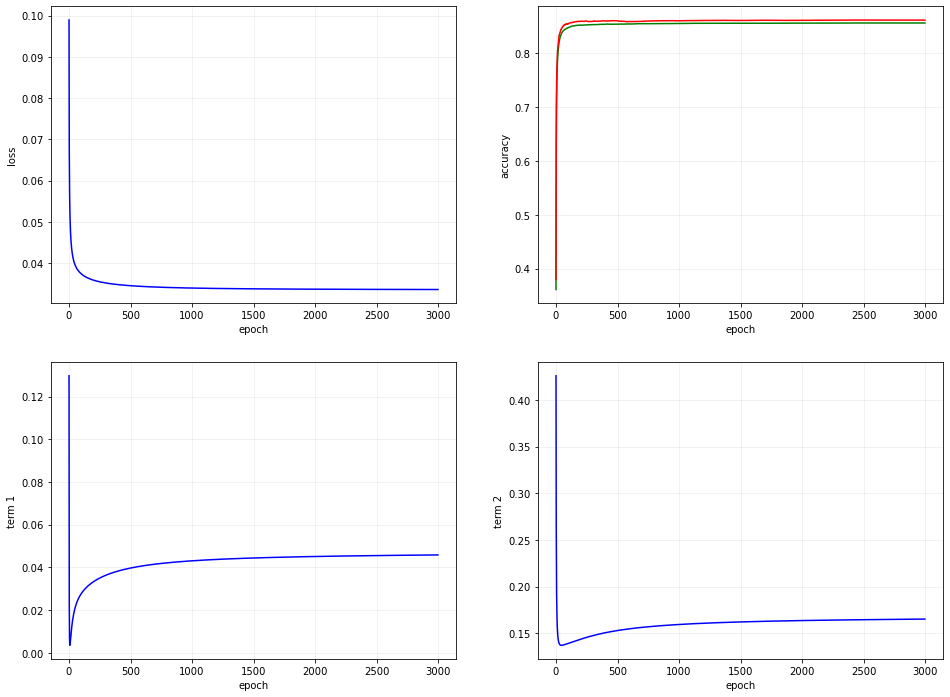

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

axs[0][0].plot(loss_tab, color='blue')
axs[0][1].plot(train_accuracy_tab, color='green')
axs[0][1].plot(test_accuracy_tab, color='red')

axs[1][0].plot(term_I_tab, color = 'blue')
axs[1][1].plot(term_II_tab, color = 'blue')

for row in axs:
    for ax in row:
        ax.grid(True, alpha =0.2)
        ax.set_xlabel('epoch')
        #ax.set_yscale('log')

axs[0][0].set_ylabel('loss')
axs[0][1].set_ylabel('accuracy')
axs[1][0].set_ylabel('term 1')
axs[1][1].set_ylabel('term 2')
plt.show()



## Visualization of mapping of the model

In [34]:
params=[]
for param in model.parameters():
    params.append(param.detach().numpy())
w1=params[0] 
w2=params[1]


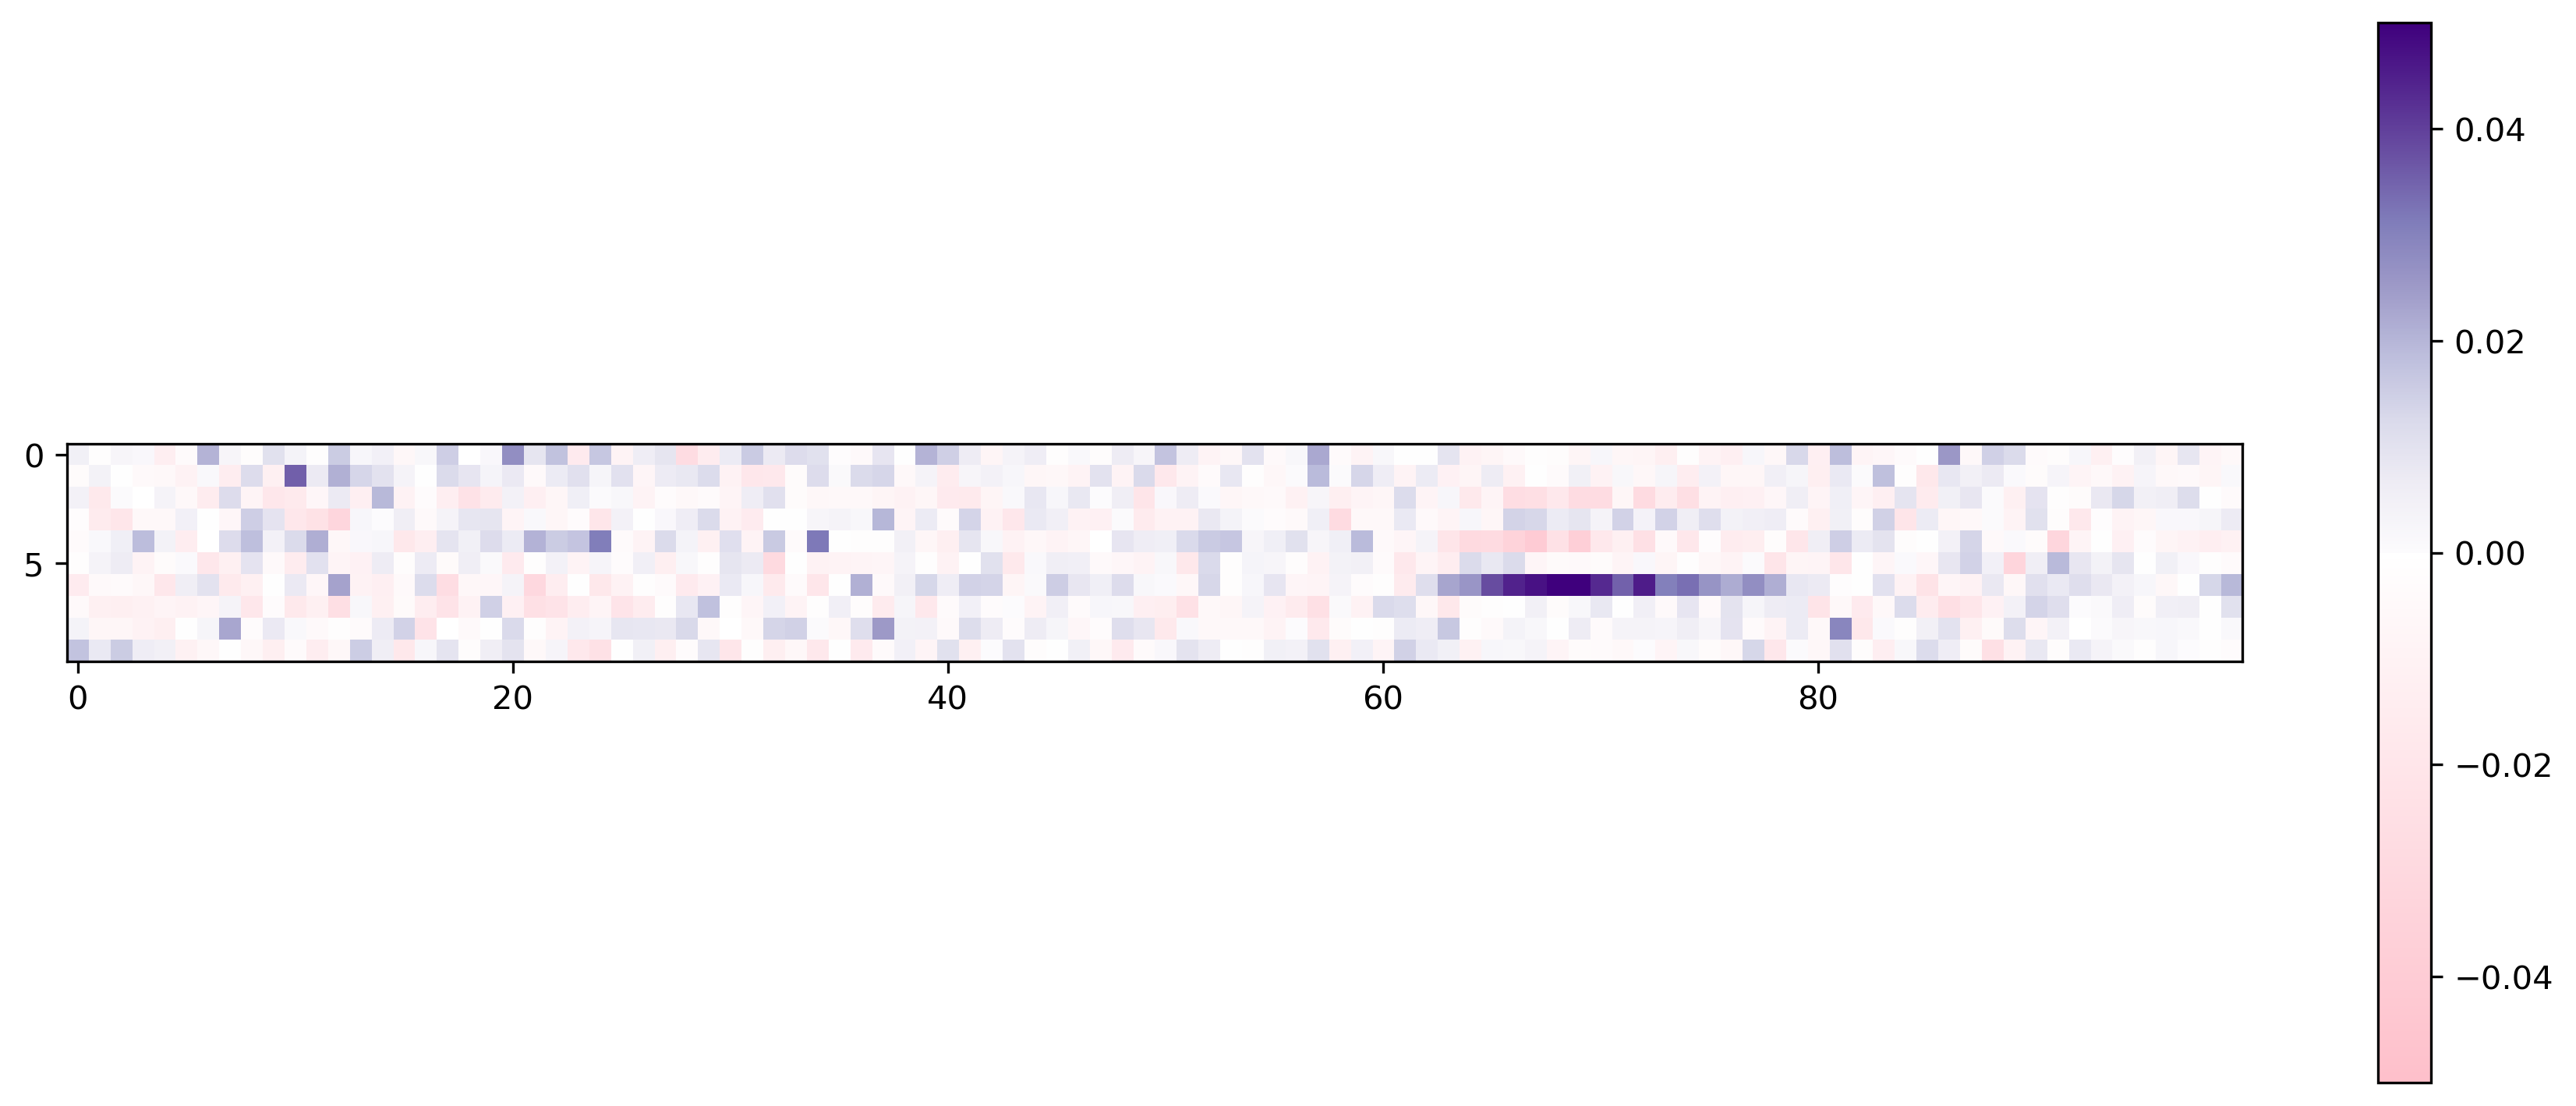

In [35]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW =  w2 @ w1 
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


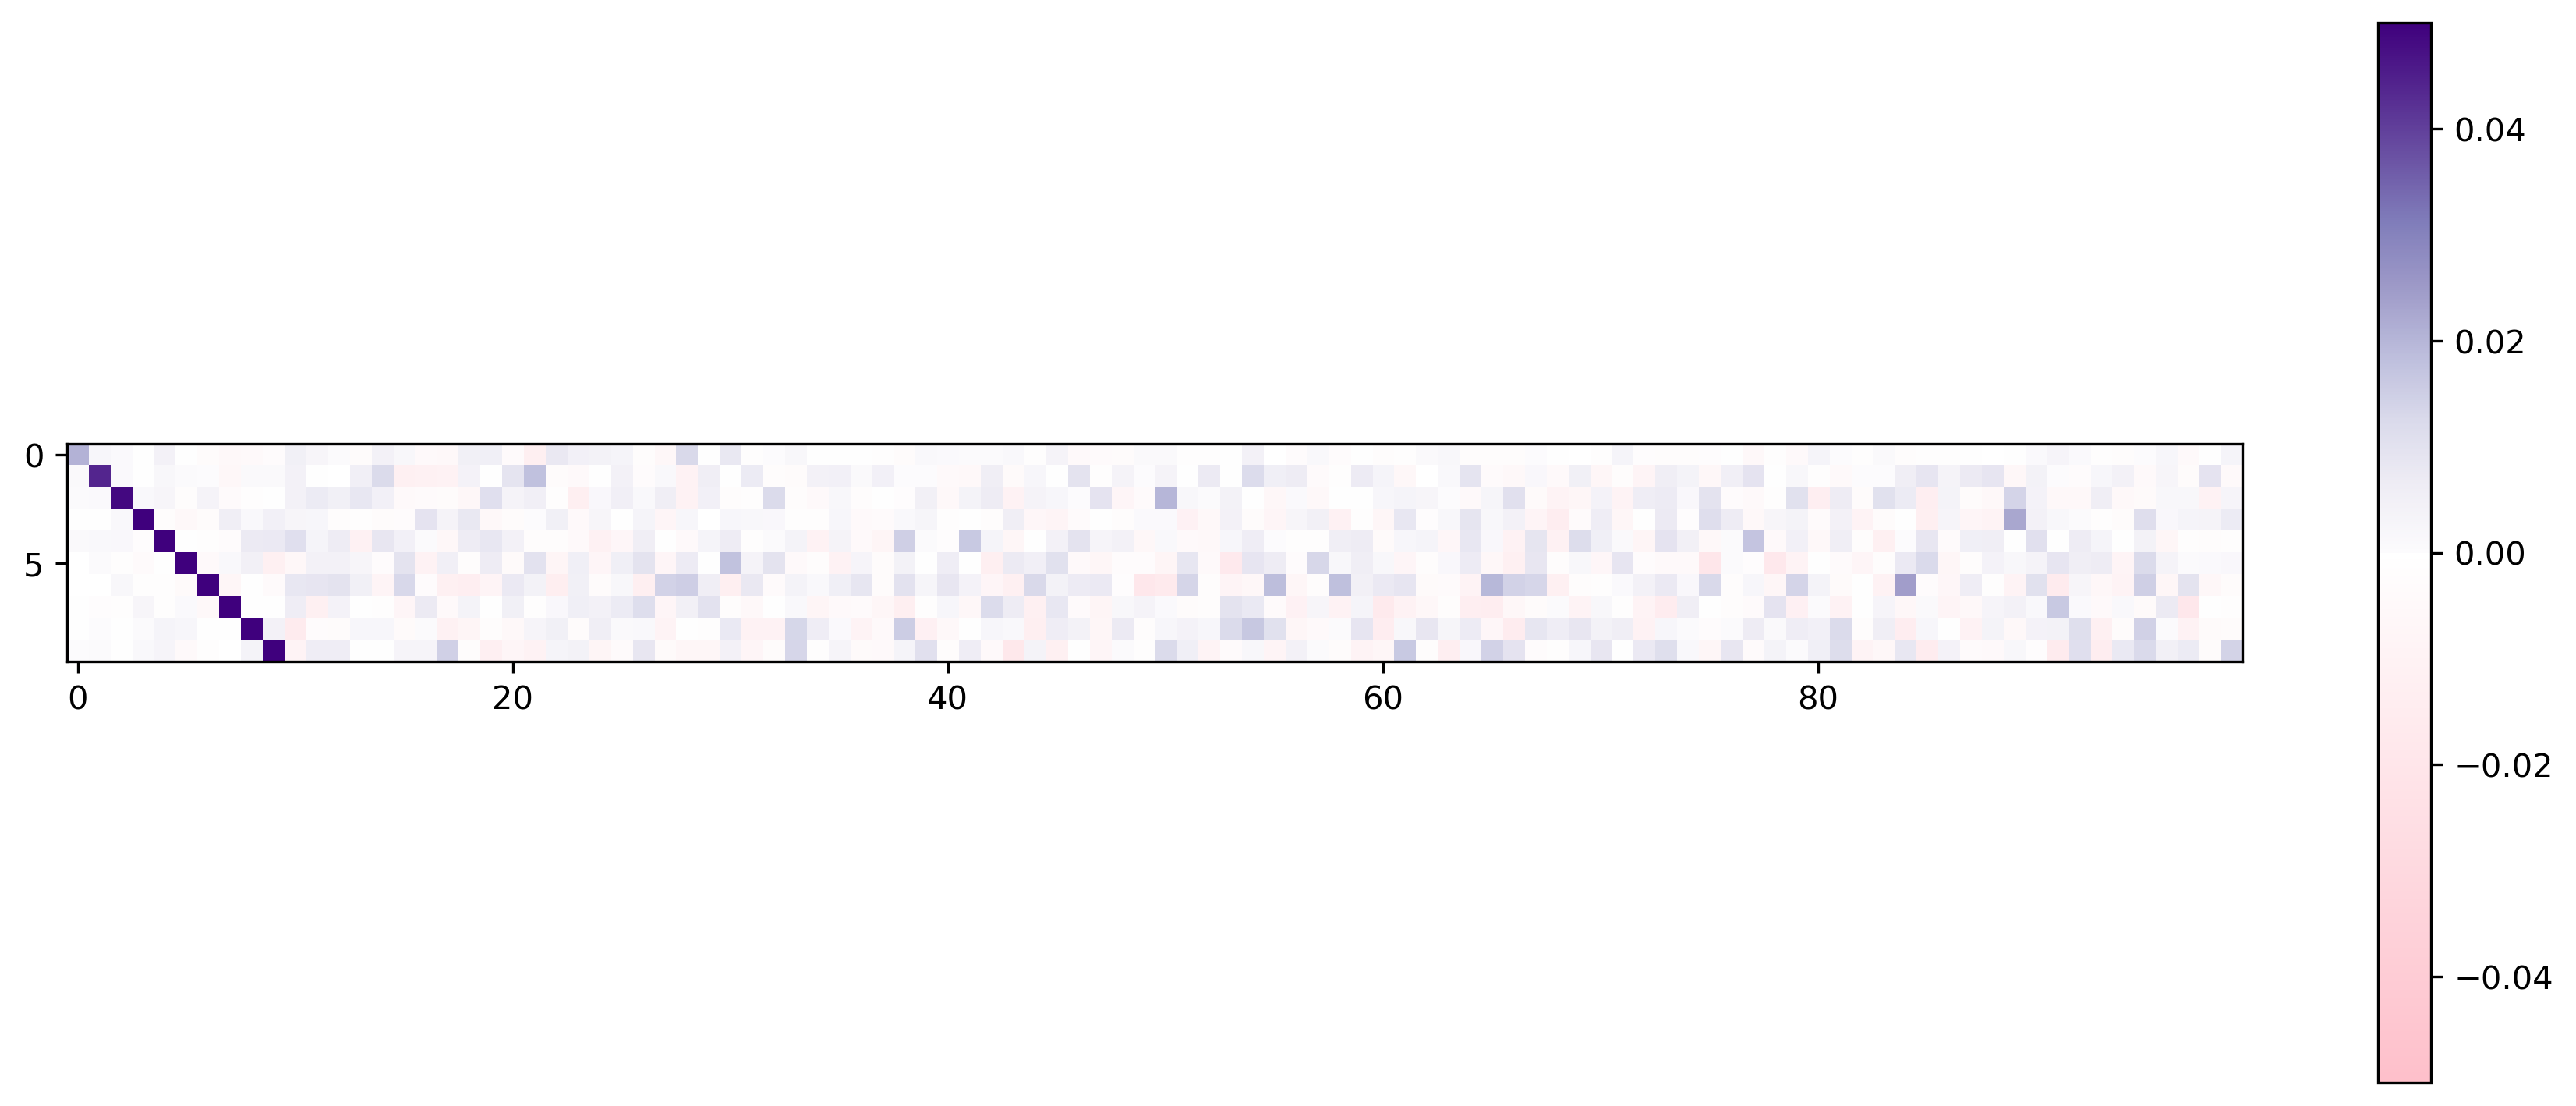

In [36]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


CHECK: $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$
$$ MSE= \frac{1}{P} \sum_{\mu=1}^P \lVert y - W^2 W^1 x \rVert ^2 $$ 

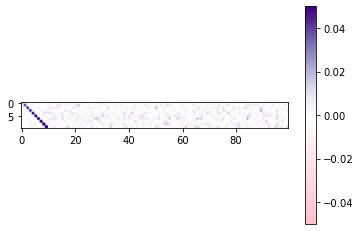

In [37]:
R = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( R[:, :100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

## Calculation of terms

In [38]:
term_1 = 0
for alpha in range(10):
    term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
term_1



array([0.04587614])

In [39]:
term_2 = 0
for beta in range(10):
    for alpha in range(784):
        if(alpha != beta):
            term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
term_2


0.16518361289106515

In [40]:
term_3 = np.trace(S33_matrix)
term_3

1.000000009

In [41]:
term_4 = 0
for alpha in range(10):
    term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]
term_4   

array([0.49717632])

In [42]:
term_1+term_2+term_3-term_4

array([0.71388344])

In [43]:
term_3-term_4

array([0.50282369])

## terms with star: $T_1^*$,  $T_2^*$,  $T_4^*$

In [44]:
term_4 = 0
for alpha in range(10):
    term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
term_4   

0.7841922454850333

In [45]:
term_3-term_4

0.21580776351496678

In [46]:
term_2+term_3-term_4

0.38099137640603187

In [47]:
term_1+term_2+term_3-term_4

array([0.42686751])

# Final MSE on training / testing dataset


In [48]:
MSE_tab=[]
SE_model_tab=[]
SE_calc_tab=[]

batch_size: int = 1  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [49]:
with torch.no_grad():
    for i, (x,y) in enumerate(train_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc = w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on training set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on training set
MSE = 0.038252 	MSE_model = 0.382519	MSEcalc = 0.382519


In [50]:
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc =  w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on test set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on test set
MSE = 0.038260 	MSE_model = 0.382597	MSEcalc = 0.382597


# Save all


In [51]:
import pandas as pd

savefile = 'ground_energy_100.csv'
df = pd.DataFrame()

df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab


df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab
df['R'] = R_tab


df.to_csv(savefile, index=False)

df_w2= pd.DataFrame(np.array(w2_tab).T)
df_w3= pd.DataFrame(np.array(w3_tab).T)

df_w2.to_csv('ground_energy_100_w2.csv', index=False)
df_w3.to_csv('ground_energy_100_w3.csv', index=False)


In [53]:
w1=deepcopy(model.parameters()[0]).detach().numpy().reshape(input_dim*hidden_dim1)
w2=deepcopy(model.parameters()[1]).detach().numpy().reshape(hidden_dim1*output_dim)

df_w1 = pd.DataFrame(w1, columns = ['w1'] )
df_w2 = pd.DataFrame(w2, columns = ['w2'] )

df_w1.to_csv('w1.csv', index=False)
df_w2.to_csv('w2.csv', index=False)
